In [1]:
import pandas as pd
import numpy as np
import glob as gb
import re
import itertools as it
from sklearn.linear_model import LogisticRegression
from PIL import Image as ig
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestRegressor
from scipy.spatial.distance import dice

from utils import create_submission, rle_encoding

SyntaxError: non-default argument follows default argument (utils.py, line 53)

In [2]:
img_train = pd.read_csv("comp-540-spring-2019/train.csv")

In [51]:
#loading .jpg

img1 = ig.open("comp-540-spring-2019/train/31650_sat.jpg")
img1_RGB = img1.convert('RGB')

img1_msk = ig.open("comp-540-spring-2019/train/10001_msk.png")
img1_msk_RGB = img1_msk.convert('RGB')


In [52]:
img1_RGB.getpixel((0,200))

(110, 91, 61)

In [53]:
img1_msk_RGB.getpixel((0,200))

(255, 255, 255)

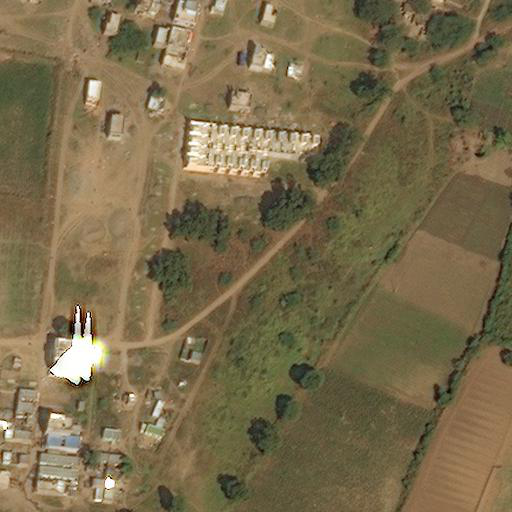

In [54]:
img1

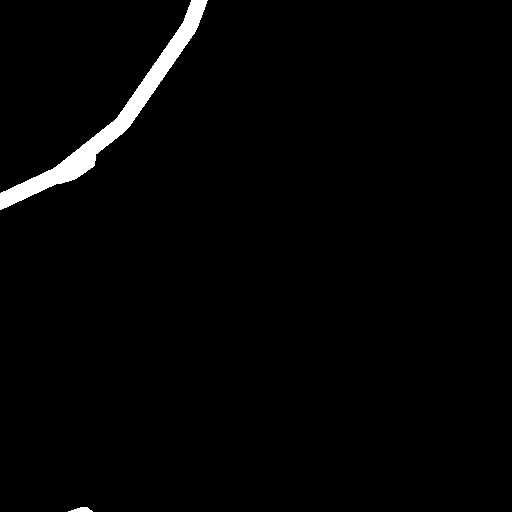

In [8]:
img1_msk

In [3]:
%%time

# Elliot's attempt

num_of_imgs = 5
height = 512
width = 512
row_count = range(height * width)
columns = ['ImageNumber', 'Height', 'Width', 'R', 'G', 'B', 'Lightness', 'Mask', 'Road']
col_count = len(columns)

X_train = np.zeros(shape=(num_of_imgs, height * width, 3))
y_train = np.zeros(shape = (num_of_imgs, height * width, 1))

img_names = gb.glob("comp-540-spring-2019/train/*.jpg")
img_numbers = [re.findall(r'/(\d+)', img_name) for img_name in img_names]
img_nums = sample(list(it.chain.from_iterable(img_numbers))

for i in range(num_of_imgs):
    
    img = ig.open("comp-540-spring-2019/train/" + img_nums[i] + "_sat.jpg")
    msk = ig.open("comp-540-spring-2019/train/" + img_nums[i] + "_msk.png")
    img_mat = list(img.getdata())
    y = [pix[0] for pix in list(msk.getdata())]
    y_bool = (np.array(y) == 255) * 1
    
    X_train[i] = img_mat
    y_train[i] = y_bool[:, np.newaxis]


SyntaxError: invalid syntax (<unknown>, line 18)

NameError: name 'img_mat' is not defined

In [ ]:
%%time
# Building some features

num_imgs = len(X_train)
imgs = np.random.choice(range(len(X_train)), size = num_imgs)

X_train_feats = []
neighborhoods = [1 << exponent for exponent in range(1, 9)]

for img in range(num_imgs):
    temp_df = pd.DataFrame(X_train[imgs[img]])
    temp_df.columns = ["R", "G", "B"]
    temp_df["Lightness"] = (temp_df[["R", "G", "B"]].max(axis = 1) + temp_df[["R", "G", "B"]].max(axis = 1)) / 2
    
    for neighbor in neighborhoods:
        temp_n = ig.fromarray(np.uint8(X_train[imgs[img]].reshape((512, 512, 3)))).resize((neighbor, neighbor))
        temp_n_low_res = temp_n.resize((512, 512))
        temp_n_mat = pd.DataFrame(list(temp_n_low_res.getdata()))
        temp_n_mat.columns = ["R", "G", "B"]
        temp_df[("R_" + chr(neighbor))] = temp_n_mat["R"]
        temp_df[("G_" + chr(neighbor))] = temp_n_mat["G"]
        temp_df[("B_" + chr(neighbor))] = temp_n_mat["B"]
    
    X_train_feats.append(temp_df)

y_model = np.concatenate(y_train[imgs], axis = 0)
X_model = np.concatenate(X_train_feats, axis = 0)
DF_model = pd.DataFrame(np.concatenate([X_model, y_model], axis = 1))


In [92]:
%%time

height = 512
width = 512

test_ar = X_train[249]
test_out = np.zeros(X_train[249].shape)

# height = 3
# width = 3

# test_ar = np.array([[1,2,3],[4,5,6],[7,8,9],[1,2,3],[4,5,6],[7,8,9],[1,2,3],[4,5,6],[7,8,9]])
# test_out = np.zeros((9, 3))

for i in range(len(test_ar)):
    
    if (i % width == 0):
        
        # print(i)
        
        if (i < height):
            
            # print(i)
            
            test_out[i] = test_ar[i] + test_ar[i + 1] + test_ar[i + height]
            
        elif (i >= ((width * height) - height)):
            
            # print(i)
            
            test_out[i] = test_ar[i] + test_ar[i + 1] + test_ar[i - height]
            
        else:
            
            # print(i)
            
            test_out[i] = test_ar[i] + test_ar[i + 1] + test_ar[i - height] + test_ar[i + height]
    
    elif ((i + 1) % width == 0):
        
        # print(i)

        if (i < height):
            
            # print(i)
            
            test_out[i] = test_ar[i] + test_ar[i - 1] + test_ar[i + height]
            
        elif (i >= ((width * height) - height + 1)):
            
            # print(i)
            
            test_out[i] = test_ar[i] + test_ar[i - 1] + test_ar[i - height]
            
        else:
            
            # print(i)
            
            test_out[i] = test_ar[i] + test_ar[i - 1] + test_ar[i - height] + test_ar[i + height]
        
    else:
        
        # print(i)
        
        if (i < height):
            
            # print(i)
            
            test_out[i] = test_ar[i] + test_ar[i - 1] + test_ar[i + 1] + test_ar[i + height]
            
        elif (i >= ((width * height) - height + 1)):
            
            # print(i)
            
            test_out[i] = test_ar[i] + test_ar[i - 1] + test_ar[i + 1] + test_ar[i - height]
            
        else:
            
            # print(i)
            
            test_out[i] = test_ar[i] + test_ar[i - 1] + test_ar[i + 1] + test_ar[i - height] + test_ar[i + height]
    
print(test_ar[3])
print(test_ar[514])
print(test_ar[515])
print(test_ar[516])
print(test_ar[1027])
    
print(test_out[515])

[65. 85. 57.]
[61. 81. 53.]
[54. 74. 46.]
[48. 68. 40.]
[59. 79. 51.]
[287. 387. 247.]
CPU times: user 928 ms, sys: 8.37 ms, total: 937 ms
Wall time: 933 ms


In [10]:
#Non-Random subset

train_X, test_X, train_y, test_y = train_test_split(DF_model[DF_model.columns[0:28]], DF_model[DF_model.columns[28]], test_size = 0.10)


In [24]:
#Random subset

subset_proportion = .1

DF_sample = DF_model.sample(int((DF_model.shape[0]) * subset_proportion))

train_X, test_X, train_y, test_y = train_test_split(DF_sample[DF_sample.columns[0:28]], DF_sample[DF_sample.columns[28]], test_size = 0.5)


In [25]:
#Simple model - Logistic Regression

logreg = LogisticRegression()

lgfit = logreg.fit(train_X, train_y)

pred_y = lgfit.predict(test_X)

In [26]:
print(confusion_matrix(test_y, pred_y))
print(classification_report(test_y, pred_y))

[[3029723     355]
 [ 115648       2]]
             precision    recall  f1-score   support

        0.0       0.96      1.00      0.98   3030078
        1.0       0.01      0.00      0.00    115650

avg / total       0.93      0.96      0.95   3145728



In [25]:
#Random Forest

rf = RandomForestRegressor(n_estimators = 300, random_state = 123)

rffit = rf.fit(train_X, train_y)

#pred_y = np.round(rf.predict(test_X))

In [26]:
#Evaluation metrics

pred_y = np.round(rf.predict(test_X))

pred_y = np.round(pred_y)
conf_mat = confusion_matrix(test_y, pred_y)
print(conf_mat)
print(classification_report(test_y, pred_y))
print(1 - dice(pred_y, test_y))

[[256883    426]
 [  1222   3613]]
             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00    257309
        1.0       0.89      0.75      0.81      4835

avg / total       0.99      0.99      0.99    262144

0.8142889339643904


In [27]:
#Dice coefficient manually

print((2 * conf_mat[1][1]) / ((2 * conf_mat[1][1]) + conf_mat[0][1] + conf_mat[1][0]))

0.8142889339643904


In [ ]:
#Predicting on validation set
# All at once

num_of_imgs = 2000
height = 512
width = 512
row_count = range(height * width)
columns = ['ImageNumber', 'Height', 'Width', 'R', 'G', 'B', 'Lightness', 'Mask', 'Road']
col_count = len(columns)

X_val = np.zeros(shape=(num_of_imgs, height * width, 3))

img_names = gb.glob("comp-540-spring-2019/val/*.jpg")
img_numbers = [re.findall(r'/(\d+)', img_name) for img_name in img_names]
img_nums = list(it.chain.from_iterable(img_numbers))

for i in range(num_of_imgs):
    
    img = ig.open("comp-540-spring-2019/val/" + img_nums[i] + "_sat.jpg")
    img_mat = list(img.getdata())
    
    X_val[i] = img_mat


# Building some features

num_imgs = len(X_val)
imgs = np.random.choice(range(len(X_val)), size = num_imgs)

X_val_feats = []
neighborhoods = [1 << exponent for exponent in range(1, 9)]

for img in range(num_imgs):
    temp_df = pd.DataFrame(X_val[imgs[img]])
    temp_df.columns = ["R", "G", "B"]
    temp_df["Lightness"] = (temp_df[["R", "G", "B"]].max(axis = 1) + temp_df[["R", "G", "B"]].max(axis = 1)) / 2
    
    for neighbor in neighborhoods:
        temp_n = ig.fromarray(np.uint8(X_val[imgs[img]].reshape((512, 512, 3)))).resize((neighbor, neighbor))
        temp_n_low_res = temp_n.resize((512, 512))
        temp_n_mat = pd.DataFrame(list(temp_n_low_res.getdata()))
        temp_n_mat.columns = ["R", "G", "B"]
        temp_df[("R_" + chr(neighbor))] = temp_n_mat["R"]
        temp_df[("G_" + chr(neighbor))] = temp_n_mat["G"]
        temp_df[("B_" + chr(neighbor))] = temp_n_mat["B"]
    
    X_val_feats.append(temp_df)

X_model = np.vstack(X_val_feats)
DF_model_val = pd.DataFrame(X_model)

X_model_val = DF_model_val

pred_y_val = np.round(rf.predict(X_model_val))


In [2]:
# Predicting on validation one by one

height = 512
width = 512
row_count = range(height * width)
columns = ['ImageNumber', 'Height', 'Width', 'R', 'G', 'B', 'Lightness', 'Mask', 'Road']
col_count = len(columns)

img_names = gb.glob("comp-540-spring-2019/val/*.jpg")
img_numbers = [re.findall(r'/(\d+)', img_name) for img_name in img_names]
img_nums = list(it.chain.from_iterable(img_numbers))

num_of_imgs = len(img_nums)

neighborhoods = [1 << exponent for exponent in range(1, 9)]

submission = []

for i in range(num_of_imgs):
    
    img = ig.open("comp-540-spring-2019/val/" + img_nums[i] + "_sat.jpg")
    img_mat = np.array(list(img.getdata()))
    
    #Building features
    temp_df = pd.DataFrame(img_mat)
    temp_df.columns = ["R", "G", "B"]
    temp_df["Lightness"] = (temp_df[["R", "G", "B"]].max(axis = 1) + temp_df[["R", "G", "B"]].max(axis = 1)) / 2
    
    for neighbor in neighborhoods:
        temp_n = ig.fromarray(np.uint8(img_mat.reshape((512, 512, 3)))).resize((neighbor, neighbor))
        temp_n_low_res = temp_n.resize((512, 512))
        temp_n_mat = pd.DataFrame(list(temp_n_low_res.getdata()))
        temp_n_mat.columns = ["R", "G", "B"]
        temp_df[("R_" + chr(neighbor))] = temp_n_mat["R"]
        temp_df[("G_" + chr(neighbor))] = temp_n_mat["G"]
        temp_df[("B_" + chr(neighbor))] = temp_n_mat["B"]
    
    
    temp_y_pred = np.round(rf.predict(temp_df))
    
    submission.append(temp_y_pred.reshape((512, 512)))
    
    
    

NameError: name 'gb' is not defined

In [ ]:
submission = []

for i in img_val:
    Model1FeatureEngineering()
    submission.append(model.predict(generator(img_val)))

In [66]:
create_submission("sub_stacked.csv", np.array(submission), np.array(img_nums))

1 20
3 20
5 20
7 20
9 20
11 20
13 20
15 20
17 20
19 20


In [63]:
np.array(submission).shape

(20, 512, 512)

In [65]:
len(img_nums)

20

In [2]:
test_arr = np.repeat(submission[20][:, :, np.newaxis], 3, axis = 2) * 255
test_img = ig.fromarray(np.uint8(test_arr))
test_img

NameError: name 'np' is not defined

In [ ]:
def create_submission(csv_name, predictions, image_ids):
    """
    csv_name -> string for csv ("XXXXXXX.csv")
    predictions -> numpyarray of size (num_examples, height, width)
                In this case (num_examples, 512, 512)
    image_ids -> numpyarray or list of size (num_examples,)
    
    predictions[i] should be the prediciton of road for image_id[i]
    """
    sub = pd.DataFrame()
    sub['ImageId'] = image_ids
    encodings = []
    num_images = len(image_ids)
    for i in range(num_images):
        if (i+1) % (num_images//10) == 0:
            print(i, num_images)
        encodings.append(rle_encoding(predictions[i]))
        
    sub['EncodedPixels'] = encodings
    sub.to_csv(csv_name, index=False)

In [ ]:
##### Original attempt

# %%time

# #loading all images

# num_of_imgs = 100
# height = 512
# width = 512
# indices = range(0, (num_of_imgs * height * width))
# columns = ['ImageNumber', 'Height', 'Width', 'R', 'G', 'B', 'Lightness', 'Mask', 'Road']
# train_df = pd.DataFrame(index = indices, columns = columns)
# img_names = gb.glob("comp-540-spring-2019/train/*.jpg")
# img_numbers = [re.findall(r'/(\d+)', img_name) for img_name in img_names]
# img_nums = list(it.chain.from_iterable(img_numbers))
# img_nums = img_nums[:num_of_imgs]

# train_df.loc[:, 'ImageNumber'] = np.repeat(img_nums, height * width)
# train_df.loc[:, 'Height'] = np.repeat(np.repeat(range(0, height), width), num_of_imgs)
# train_df.loc[:, 'Width'] = list(range(0, width)) * (num_of_imgs * height)

# for img_num in range(0, num_of_imgs, 1):
#     img = ig.open("comp-540-spring-2019/train/" + img_nums[img_num] + "_sat.jpg")
#     msk = ig.open("comp-540-spring-2019/train/" + img_nums[img_num] + "_msk.png")
#     img_mat = list(img.getdata())
#     msk_mat = list(msk.getdata())
#     train_df.loc[(img_num * height * width):(((img_num + 1) * height * width) - 1), 'R':'B'] = img_mat
#     train_df.loc[(img_num * height * width):(((img_num + 1) * height * width) - 1), 'Mask'] = np.array(msk_mat)[:, 1]

# train_df["Lightness"] = (train_df[["R", "G", "B"]].max(axis = 1) + train_df[["R", "G", "B"]].max(axis = 1)) / 2
# train_df.Road = (train_df.Mask > 0)

In [ ]:
###### SEcond attempt

#loading all images - batches

# num_of_imgs = 100
# height = 512
# width = 512
# indices = range(0, (height * width))
# columns = ['ImageNumber', 'Height', 'Width', 'R', 'G', 'B', 'Lightness', 'Mask', 'Road']
# train_df = pd.DataFrame(index = [0], columns = columns)
# img_names = gb.glob("comp-540-spring-2019/train/*.jpg")
# img_numbers = [re.findall(r'/(\d+)', img_name) for img_name in img_names]
# img_nums = list(it.chain.from_iterable(img_numbers))
# img_nums = img_nums[:num_of_imgs]

# for img_num in range(0, num_of_imgs, 1):
#     img = ig.open("comp-540-spring-2019/train/" + img_nums[img_num] + "_sat.jpg")
#     msk = ig.open("comp-540-spring-2019/train/" + img_nums[img_num] + "_msk.png")
#     img_mat = list(img.getdata())
#     msk_mat = list(msk.getdata())
#     temp_df = pd.DataFrame(index = indices, columns = columns)
#     temp_df["ImageNumber"] = np.repeat(img_nums[img_num], height * width)
#     temp_df["Height"] = np.repeat(range(0, height), width)
#     temp_df["Width"] = list(range(0, width)) * height
#     temp_df[["R", "G", "B"]] = img_mat
#     temp_df["Mask"] = np.array(msk_mat)[:, 1]
#     train_df = train_df.append(temp_df)

# train_df["Lightness"] = (train_df[["R", "G", "B"]].max(axis = 1) + train_df[["R", "G", "B"]].max(axis = 1)) / 2
# train_df.Road = (train_df.Mask > 0)

In [ ]:
# #Just in case

# for img_num in range(0, num_of_imgs, 1):
#     img = ig.open("comp-540-spring-2019/train/" + str(10000 + img_num + 1) + "_sat.jpg")
#     msk = ig.open("comp-540-spring-2019/train/" + str(10000 + img_num + 1) + "_msk.png")
#     img_RGB = img.convert('RGB')
#     msk_RGB = msk.convert('RGB')
#     for h in range(0, 512):
#         print(h)
#         for w in range(0, 512):
#             print(w)
#             row_num = (((h * 512) + w) + (img_num * height * width))
#             train_df.loc[row_num, 'ImageNumber'] = img_num + 1
#             train_df.loc[row_num, 'Height'] = h
#             train_df.loc[row_num, 'Width'] = w
#             RGB = img_RGB.getpixel((h, w))
#             train_df.loc[row_num, 'R':'B'] = RGB
#             train_df.loc[row_num, 'Lightness'] = (max(RGB) + min(RGB)) / 2
#             train_df.loc[row_num, 'Road'] = (msk_RGB.getpixel((h, w))[0] > 0)